# Approximate Bayesian Computation

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

In [2]:
n, x = 8, 6
N = 100

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];

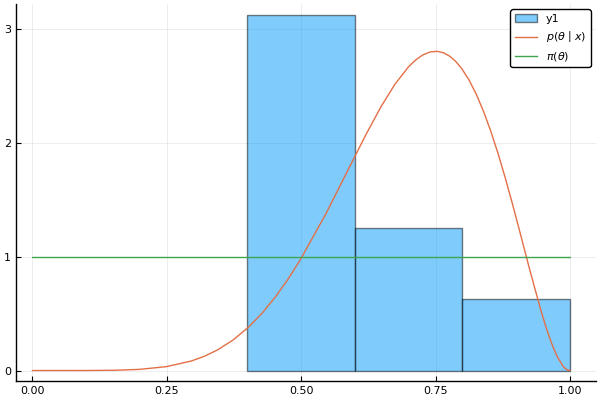

In [3]:
histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

In [4]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end



In [41]:
df = DataFrame([z,hdots]);

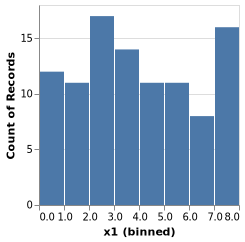

In [43]:
hist = df |> vl"""{
  "mark": "bar",
  "encoding": {
    "x": {
      "bin": true,
      "field": "x1",
      "type": "quantitative"
    },
    "y": {
      "aggregate": "count",
      "type": "quantitative"
    }
  }
}"""

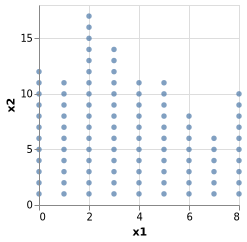

In [44]:
points = df |> vl"""
{
  "mark": "circle",
  "encoding": {
    "x": {"field": "x1", "type": "quantitative"},
    "y": {"field": "x2", "type": "quantitative"}
  }
}"""

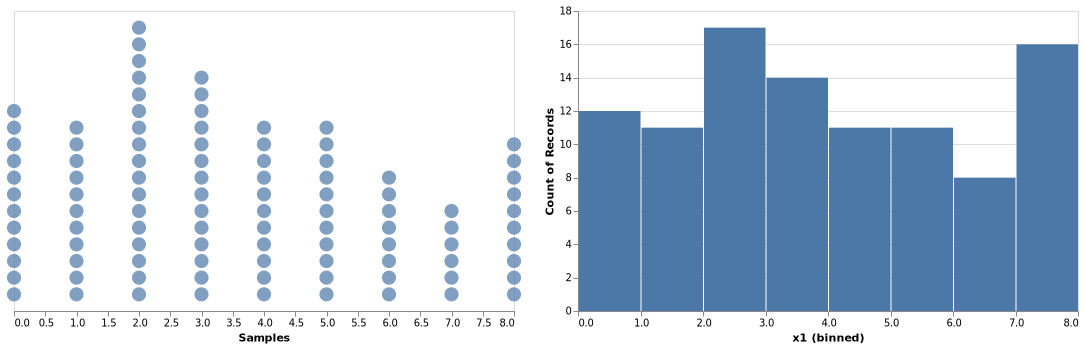

In [64]:
points = df |> vl"""
{
"hconcat" : [
  {
    "width": 500,
    "height": 300,
    "mark": "circle",
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"Samples"}},
        "y": {"field": "x2", "type": "quantitative", "axis": null},
        "size":{"value":200}
        }
    },
  {
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin": true,
        "field": "x1",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative"
      }
    }
}
]
}
"""

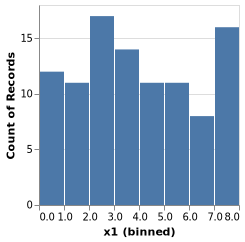

In [24]:
spec = [
@vlplot(width=800, height=300, view={stroke=nothing}) + 
@vlplot(
    data={values={"start"=5.7,"finish"=6.3, "Event"="Acceptance Region"}},
    mark={:rect, color=:green},
    x={"start:q",axis={title=""}},
    x2="finish:q",
    y={value=1,axis={ticks=false}},
    color={"Event:n",scale={range=["green"]}},
    opacity={value=0.3})+
@vlplot(
    data=df,
    mark={:circle,strokeWidth=1,stroke=:black,clip=false},
    size={value=200},
    color={value="#4682b4"},
    x={"x1:q",axis={title="Sample Values",grid=false}},
#     y={"x2:q",axis={title="count",ticks=false,grid=false}})
    y={"x2:q",axis=nothing})

]
histog = @vlplot(data=df,:bar, x={:x1, bin=true}, y="count()")


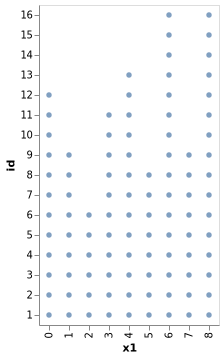

In [459]:
@vlplot(
    data=df,
    transform=[{
        window=[{op="rank","as"="id"}],
        groupby=["x1"]
    }],
    mark={:circle},
    encoding={
        x="x1:o",
        y={"id:o", "axis"=:null, "sort"="descending"}
    }
    )


In [2]:
using VegaDatasets
df = dataset("cars")

Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
"""chevrolet chevelle malibu""",18.0,8,307.0,130,3504,12.0,"""1970-01-01""","""USA"""
"""buick skylark 320""",15.0,8,350.0,165,3693,11.5,"""1970-01-01""","""USA"""
"""plymouth satellite""",18.0,8,318.0,150,3436,11.0,"""1970-01-01""","""USA"""
"""amc rebel sst""",16.0,8,304.0,150,3433,12.0,"""1970-01-01""","""USA"""
"""ford torino""",17.0,8,302.0,140,3449,10.5,"""1970-01-01""","""USA"""
"""ford galaxie 500""",15.0,8,429.0,198,4341,10.0,"""1970-01-01""","""USA"""
"""chevrolet impala""",14.0,8,454.0,220,4354,9.0,"""1970-01-01""","""USA"""
"""plymouth fury iii""",14.0,8,440.0,215,4312,8.5,"""1970-01-01""","""USA"""
"""pontiac catalina""",14.0,8,455.0,225,4425,10.0,"""1970-01-01""","""USA"""
"""amc ambassador dpl""",15.0,8,390.0,190,3850,8.5,"""1970-01-01""","""USA"""


In [3]:
df |> vl"""{
  "transform": [{"calculate": "year(datum.Year)", "as": "Year"}],
  "layer": [{
    "selection": {
      "CylYr": {
        "type": "single", "fields": ["Cylinders", "Year"],
        "init": {"Cylinders": 4, "Year": 1977},
        "bind": {
          "Cylinders": {"input": "range", "min": 3, "max": 8, "step": 1},
          "Year": {"input": "range", "min": 1969, "max": 1981, "step": 1}
        }
      }
    },
    "mark": "circle",
    "encoding": {
      "x": {"field": "Horsepower", "type": "quantitative"},
      "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
      "color": {
        "condition": {"selection": "CylYr", "field": "Origin", "type": "nominal"},
        "value": "grey"
      }
    }
  }, {
    "transform": [{"filter": {"selection": "CylYr"}}],
    "mark": "circle",
    "encoding": {
      "x": {"field": "Horsepower", "type": "quantitative"},
      "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
      "color": {"field": "Origin", "type": "nominal"},
      "size": {"value": 100}
    }
  }]
}
"""

LoadError: UndefVarError: @vl_str not defined